# UFC Data Analysis

In [2]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
import sys
import re
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt

## WebScrapping 

### Webscrapping Code

In [2]:
# Retrieve all the necessary links
def get_event_links(num_pages):
    total_events_links = []
    for page_number in range(1,num_pages+1):
        res = requests.get('https://www.sherdog.com/organizations/Ultimate-Fighting-Championship-UFC-2/recent-events/' + str(page_number))
        soup = BeautifulSoup(res.text, 'html.parser')
        time.sleep(1)
        links = soup.find_all('a')
        page_links = []
        for link_path in links:
            if link_path['href'].find('/events/') != -1:
                page_links.append(link_path['href'])
        total_events_links.extend(page_links[13:113])
    return total_events_links

all_ufc_event_links = get_event_links(num_pages = 6)

In [ ]:
# Get information related to the events

def get_info_from_events(event_links):
    webscrapped_dataset = []
    for event_link in event_links:
        res = requests.get('https://www.sherdog.com' + event_link)
        soup = BeautifulSoup(res.text, 'html.parser')
        time.sleep(0.5)
        event_table = pd.DataFrame()
        # Retrieve information by event
        event_name = soup.find('h1').text
        search = soup.find('div', class_ = "info")
        event_date = search.find('meta', attrs={'itemprop': 'startDate'})['content']
        event_location = search.find_all('span')[1].text

        # Keep only the events that weren't cancelled
        if event_location.find('EVENT CANCELED') == -1:
            winner_fighter_col = []
            looser_fighter_col = []
            match_number_col = []
            method_col = []
            referee_col = []
            number_rounds_col = []
            round_time_col = []
            weight_class_col = []

            ##################### Main Fight #####################################
            
            # Winner 
            search = soup.find('div', class_ = "fighter left_side").find('h3')
            winner_fighter_col.append(search.text)
            # Looser 
            search = soup.find('div', class_ = "fighter right_side").find('h3')
            looser_fighter_col.append(search.text)

            # Match Number / Method Referee / number_rounds / round_time
            search = soup.find('table', class_ = "fight_card_resume").find_all('td')
            match_number_col.append(search[0].text)
            method_col.append(search[1].text)
            referee_col.append(search[2].text)
            number_rounds_col.append(search[3].text)
            round_time_col.append(search[4].text)

            # Weight Class
            search = soup.find('span' , "weight_class" )
            weight_class_col.append(search.text)

            ###################### Other fights #############################################    
            search = soup.find('table', class_ = "new_table result").find_all('tr' , attrs={'itemprop':'subEvent'})
            for each_item in np.arange(0,len(search)):
                # Match Number / Winner_Fighter / Looser Fighter / Weight Class / Method / Referee / Number of Rounds / Round Time
                match_number_col.append(search[each_item].find('td').text)
                weight_class_col.append(search[each_item].find('span', class_ = 'weight_class').text)
                method_col.append(search[each_item].find('td' , class_ = 'winby').text.split('\n')[0])
                referee_col.append(search[each_item].find('td' , class_ = 'winby').text.split('\n')[1])
                number_rounds_col.append(search[each_item].find_all('td')[-2].text)
                round_time_col.append(search[each_item].find_all('td')[-1].text)
                winner_fighter_col.append(search[each_item].find('meta')['content'].split(' vs ')[0])
                looser_fighter_col.append(search[each_item].find('meta')['content'].split(' vs ')[1])

            ## Assign values to the 
            event_table['winner_fighter'] = winner_fighter_col
            event_table['looser_fighter'] = looser_fighter_col
            event_table['match_number'] = match_number_col
            event_table['method'] = method_col
            event_table['referee'] = referee_col
            event_table['number_rounds'] = number_rounds_col
            event_table['round_time'] = round_time_col
            event_table['weight_class'] = weight_class_col
            event_table['event_date'] = event_date
            event_table['event_location'] = event_location
            event_table['event_name'] = event_name

            webscrapped_dataset.append(event_table)
    webscrapped_dataset = pd.concat(webscrapped_dataset, ignore_index=True)
    return webscrapped_dataset

UFC_Web_Data = get_info_from_events(all_ufc_event_links)
UFC_Web_Data.to_csv('webscrapped.csv',index=False)

In [3]:
# Data Preparation - WebScrapped Information

webscrapped = pd.read_csv('C:\\Users\\Yuri_Almeida\\Documents\\Personal\\Coding_3\\Project\\webscrapped.csv')
webscrapped.info()
webscrapped.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6518 entries, 0 to 6517
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   winner_fighter  6518 non-null   object
 1   looser_fighter  6518 non-null   object
 2   match_number    6518 non-null   object
 3   method          6518 non-null   object
 4   referee         6518 non-null   object
 5   number_rounds   6518 non-null   object
 6   round_time      6518 non-null   object
 7   weight_class    4858 non-null   object
 8   event_date      6518 non-null   object
 9   event_location  6518 non-null   object
 10  event_name      6518 non-null   object
dtypes: object(11)
memory usage: 560.3+ KB


,winner_fighter,looser_fighter,match_number,method,referee,number_rounds,round_time,weight_class,event_date,event_location,event_name
0,\nColby Covington\n,\nJorge Masvidal\n,Match 13,Method Decision (Unanimous),Referee Herb Dean,Round 5,Time 5:00,Welterweight,2022-03-05T00:00:00-08:00,"T-Mobile Arena, Las Vegas, Nevada, United States",UFC 272 - Covington vs. Masvidal
1,Rafael dos Anjos,Renato Carneiro,\n\n\n 12 ...,Decision (Unanimous),Marc Goddard,5,5:00,160lb Catchweight,2022-03-05T00:00:00-08:00,"T-Mobile Arena, Las Vegas, Nevada, United States",UFC 272 - Covington vs. Masvidal
2,Bryce Mitchell,Edson Barboza,\n\n\n 11 ...,Decision (Unanimous),Mark Smith,3,5:00,Featherweight,2022-03-05T00:00:00-08:00,"T-Mobile Arena, Las Vegas, Nevada, United States",UFC 272 - Covington vs. Masvidal
3,Kevin Holland,Alex Oliveira,\n\n\n 10 ...,TKO (Elbows),Chris Tognoni,2,0:38,Welterweight,2022-03-05T00:00:00-08:00,"T-Mobile Arena, Las Vegas, Nevada, United States",UFC 272 - Covington vs. Masvidal
4,Sergey Spivak,Greg Hardy,\n\n\n 9 ...,TKO (Punches),Marc Goddard,1,2:16,Heavyweight,2022-03-05T00:00:00-08:00,"T-Mobile Arena, Las Vegas, Nevada, United States",UFC 272 - Covington vs. Masvidal


### Data Preparation

In [4]:
# Remove Non-Numeric Characters from Match_Number Column
webscrapped['match_number'] = webscrapped['match_number'].apply(lambda x: re.sub("[^0-9]", "", x))

# Remove \n character from winner and loosser
webscrapped['winner_fighter'] = webscrapped['winner_fighter'].apply(lambda x: re.sub("\n", "", x))
webscrapped['looser_fighter'] = webscrapped['looser_fighter'].apply(lambda x: re.sub("\n", "", x))

# Remove weight from weight_class
webscrapped['weight_class'] = webscrapped['weight_class'].apply(lambda x: ''.join([i for i in str(x) if not i.isdigit()]))
webscrapped['weight_class'] = webscrapped['weight_class'].apply(lambda x: re.sub("lb ", "", x))
webscrapped['weight_class'] = webscrapped['weight_class'].apply(lambda x: re.sub("lb", "", x))

# Remove strings for number_of_rounds
webscrapped['number_rounds'] = webscrapped['number_rounds'].apply(lambda x: re.sub('Round ', "", x))

# Remove Time from round_time and prepare second columns 
webscrapped['round_time'] = webscrapped['round_time'].apply(lambda x: re.sub('Time ', "", x))
webscrapped[['round_time_min', 'round_time_sec']] = webscrapped['round_time'].str.split(':', expand=True)

# Get fight time in seconds
def get_fight_time_in_sec(x):
    if x.round_time_sec == '00':
        return int(x.number_rounds) * int(x.round_time_min) * 60
    else:
        return (int(x.number_rounds) - 1) * 300 + int(x.round_time_min) * 60 + int(x.round_time_sec)

webscrapped['total_fight_in_seconds'] = webscrapped.apply(lambda x: get_fight_time_in_sec(x), axis=1)

# Get Method - Main Category 
webscrapped['method_category'] = webscrapped['method'].apply(lambda x: x[0:x.find("(")-1])
webscrapped['method_category'] = webscrapped['method_category'].apply(lambda x: re.sub('Method ',"", x))
webscrapped['method_category'] = np.where(webscrapped['method_category'] == 'No Conte', 'No Contest', webscrapped['method_category'])
webscrapped['method_category'] = np.where(webscrapped['method_category'] == 'Technical Submission', 'Submission', webscrapped['method_category'])
webscrapped['method_category'] = np.where(webscrapped['method_category'] == 'Technical Decision', 'Decision', webscrapped['method_category'])
webscrapped['method_category'] = np.where(webscrapped['method_category'] == 'KO', 'TKO', webscrapped['method_category'])

# Get Method - Main SubCategory
webscrapped['method_subcategory'] = webscrapped['method'].apply(lambda x: x[x.find("(")+1:x.find(")")])
# Category - Submission
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Arm-Triangle Choke', 'Triangle Choke', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Armlock', 'Armbar', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Straight Armbar', 'Armbar', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Straight Armlock', 'Armbar', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Ambar', 'Armbar', webscrapped['method_subcategory'])
# Category - No Contest
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Eye Poke', 'Accidental Eye Poke', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'].str.contains('Overturned by'), 'Overturned', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'].str.contains('Failed Drug Test'), 'Failed Drug Test', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Sakara Kicked in Groin', 'Illegal Knee', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'No Contes', 'Other', webscrapped['method_subcategory'])
# Category - Disqualifications
webscrapped['method_subcategory'][webscrapped.method_category == 'Disqualification'] = np.where(webscrapped['method_subcategory'].str.contains('Kick'), 'Illegal Upkick', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Elbows to Back of Head', 'Illegal Elbows', webscrapped['method_subcategory'])
# Category - Disqualifications
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Punch', 'Punches', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Elbows and Punches', 'Punches and Elbows', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Submission to Punches', 'Punches', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Knees and Punches', 'Knee and Punches', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Elbow', 'Elbows', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Knees', 'Knee', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Punch to the Body', 'Punches', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Kick to the Body and Punches', 'Body Kick and Punches', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Elbow and Punches', 'Punches and Elbows', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Submission to Elbows', 'Elbows', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Knee to the Body', 'Knee', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Punches and Knee', 'Punches and Knees', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Punches to the Body', 'Punches', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Knees to the Body', 'Knee', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Kick to the Body', 'Body Kick', webscrapped['method_subcategory'])
webscrapped['method_subcategory'] = np.where(webscrapped['method_subcategory'] == 'Submission to Elbow', 'Elbows', webscrapped['method_subcategory'])
# HW - If you wanna reduce the Categories even more it's up to you

# Drop unecessary columns
webscrapped.drop(['method', 'round_time_min', 'round_time_sec'], inplace=True, axis=1)

C:\Users\Yuri_Almeida\AppData\Local\Temp\ipykernel_924\1280292138.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  webscrapped['method_subcategory'][webscrapped.method_category == 'Disqualification'] = np.where(webscrapped['method_subcategory'].str.contains('Kick'), 'Illegal Upkick', webscrapped['method_subcategory'])


## Kaggle Dataset

In [5]:
# Load Kaggle Dataset

# R_ and B_ prefix signifies red and blue corner fighter stats respectively
# _opp_ containing columns is the average of damage done by the opponent on the fighter
# KD is number of knockdowns
# SIG_STR_pct is significant strikes percentage
# TOTAL_STR is total strikes 'landed of attempted'
# TD_pct is takedown percentages
# SUB_ATT is no. of submission attempts
# PASS is no. times the guard was passed?
# REV is the no. of Reversals landed
# HEAD is no. of significant strinks to the head 'landed of attempted'
# BODY is no. of significant strikes to the body 'landed of attempted'
# CLINCH is no. of significant strikes in the clinch 'landed of attempted'
# GROUND is no. of significant strikes on the ground 'landed of attempted'

kaggle_data = pd.read_csv('C:\\Users\\Yuri_Almeida\\Documents\\Personal\\Coding_3\\Project\\data.csv')
kaggle_data.info()
kaggle_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6012 entries, 0 to 6011
Columns: 144 entries, R_fighter to R_age
dtypes: bool(1), float64(106), int64(28), object(9)
memory usage: 6.6+ MB


,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,...,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Bantamweight,0.000,0.0,...,0,1,0,0,Orthodox,170.18,177.80,135.0,31.0,27.0
1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Middleweight,0.500,0.0,...,0,3,0,0,Orthodox,182.88,187.96,185.0,32.0,28.0
2,Tai Tuivasa,Harry Hunsucker,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Heavyweight,NaN,NaN,...,1,3,0,0,Southpaw,187.96,190.50,264.0,32.0,28.0
3,Cheyanne Buys,Montserrat Conejo,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenStrawweight,NaN,NaN,...,0,0,0,0,Switch,160.02,160.02,115.0,28.0,25.0
4,Marion Reneau,Macy Chiasson,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenBantamweight,0.125,0.0,...,1,2,2,0,Orthodox,167.64,172.72,135.0,29.0,43.0


### Data Preparation

In [ ]:
# R_ and B_ prefix signifies red and blue corner fighter stats respectively
# _opp_ containing columns is the average of damage done by the opponent on the fighter
# KD is number of knockdowns
# SIG_STR_pct is significant strikes percentage
# TOTAL_STR is total strikes 'landed of attempted'
# TD_pct is takedown percentages
# SUB_ATT is no. of submission attempts
# PASS is no. times the guard was passed?
# REV is the no. of Reversals landed
# HEAD is no. of significant strinks to the head 'landed of attempted'
# BODY is no. of significant strikes to the body 'landed of attempted'
# CLINCH is no. of significant strikes in the clinch 'landed of attempted'
# GROUND is no. of significant strikes on the ground 'landed of attempted'

In [6]:
############################ Remove Columns #################################

# weight_class is better on the webscrapped data
# 'B_avg_SIG_STR_att', 'B_avg_SIG_STR_landed' we already have 'B_avg_SIG_STR_pct' - same for opponent
#  'B_avg_TD_att' , 'B_avg_TD_landed' we already have 'B_avg_TD_pct' - same for opp
# total fight time - let's use the webscrapped beacuse it's equal to both
# We won't use the kaggle dataset information about number of wins, draws , method, age etc. because the info it's not normalized
# Some missing columns on the referee dataset on kaggle, better use the webscrapped.
# Location is also better on the webscrapped one. 

remove_columns_general = ['date', 'location', 'Referee', 'title_bout', 'weight_class']

remove_columns_B = ['B_avg_SIG_STR_att', 'B_avg_SIG_STR_landed', 'B_avg_opp_SIG_STR_att', 'B_avg_opp_SIG_STR_landed' , 
'B_avg_TD_att' , 'B_avg_TD_landed' , 'B_avg_opp_TD_att' , 'B_avg_opp_TD_landed', 'B_avg_CTRL_time(seconds)' , 'B_avg_opp_CTRL_time(seconds)', 'B_total_time_fought(seconds)',
'B_total_rounds_fought', 'B_total_title_bouts', 'B_current_win_streak', 'B_current_lose_streak', 'B_longest_win_streak', 'B_wins', 'B_losses', 'B_draw', 'B_win_by_Decision_Majority', 
'B_win_by_Decision_Split', 'B_win_by_Decision_Unanimous', 'B_win_by_KO/TKO', 'B_win_by_Submission',	'B_win_by_TKO_Doctor_Stoppage', 'B_Stance', 'B_Height_cms', 'B_Reach_cms', 'B_Weight_lbs', 'B_age']

remove_columns_A = ['R_avg_SIG_STR_att', 'R_avg_SIG_STR_landed', 'R_avg_opp_SIG_STR_att', 'R_avg_opp_SIG_STR_landed' , 
'R_avg_TD_att' , 'R_avg_TD_landed' , 'R_avg_opp_TD_att' , 'R_avg_opp_TD_landed', 'R_avg_CTRL_time(seconds)' , 'R_avg_opp_CTRL_time(seconds)', 'R_total_time_fought(seconds)',
'R_total_rounds_fought', 'R_total_title_bouts', 'R_current_win_streak', 'R_current_lose_streak', 'R_longest_win_streak', 'R_wins', 'R_losses', 'R_draw', 'R_win_by_Decision_Majority', 
'R_win_by_Decision_Split', 'R_win_by_Decision_Unanimous', 'R_win_by_KO/TKO', 'R_win_by_Submission',	'R_win_by_TKO_Doctor_Stoppage', 'R_Stance', 'R_Height_cms', 'R_Reach_cms', 'R_Weight_lbs', 'R_age']

kaggle_data.drop(remove_columns_A, inplace=True, axis=1)
kaggle_data.drop(remove_columns_B, inplace=True, axis=1)
kaggle_data.drop(remove_columns_general, inplace=True, axis=1)


# Create Percentage Columns 
fighter_prefix = ['R_avg_', 'B_avg_']
skill_type = ['TOTAL_STR', 'HEAD', 'BODY', 'LEG', 'DISTANCE', 'CLINCH', 'GROUND']

for fighter in fighter_prefix:
    for skill in skill_type:
        # Fighter
        kaggle_data[str(fighter + skill + '_pct')] = kaggle_data[str(fighter + skill + '_landed')] /  kaggle_data[str(fighter + skill + '_att')]
        kaggle_data.drop([str(fighter + skill + '_att'), str(fighter + skill + '_landed')], inplace=True, axis=1)
        # Opponent
        kaggle_data[str(fighter + 'opp_'  + skill + '_pct')] = kaggle_data[str(fighter + 'opp_'  + skill + '_landed')] /  kaggle_data[str(fighter + 'opp_'  + skill + '_att')]
        kaggle_data.drop([str(fighter + 'opp_'  + skill + '_att'), str(fighter + 'opp_'  + skill + '_landed')], inplace=True, axis=1)

# Analytical Questions

## Question 1 - What is the impact of the knockdowns / significant strikes / submissions attempted and the accuracy of the punches in the final result of the fight?

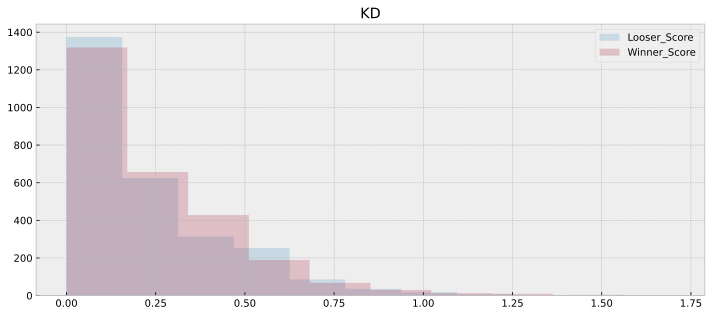

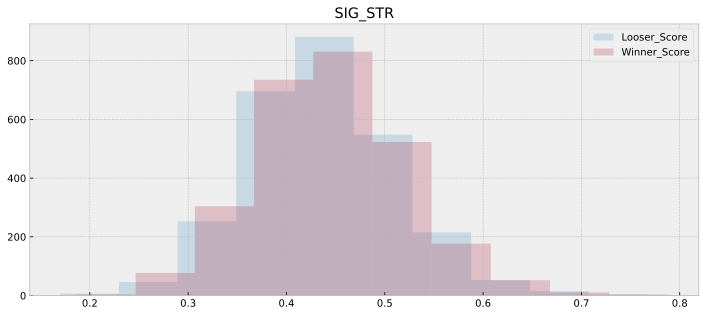

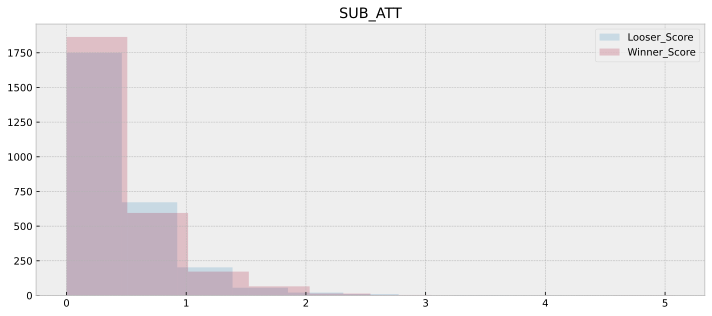

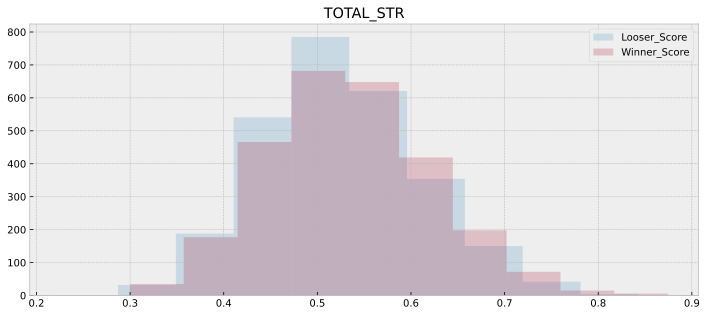

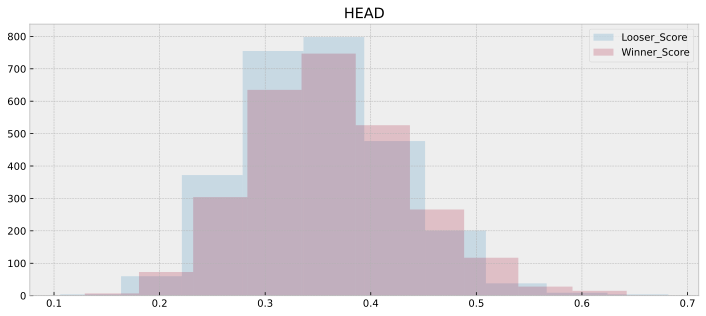

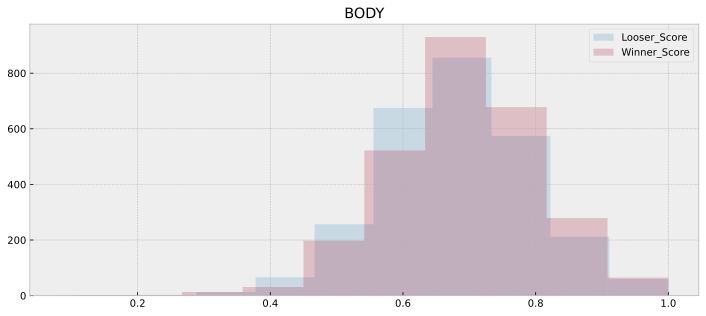

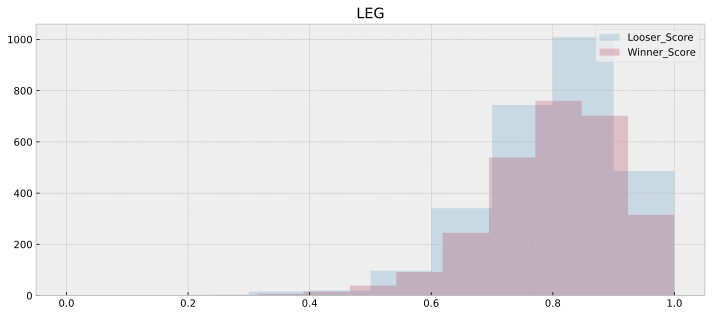

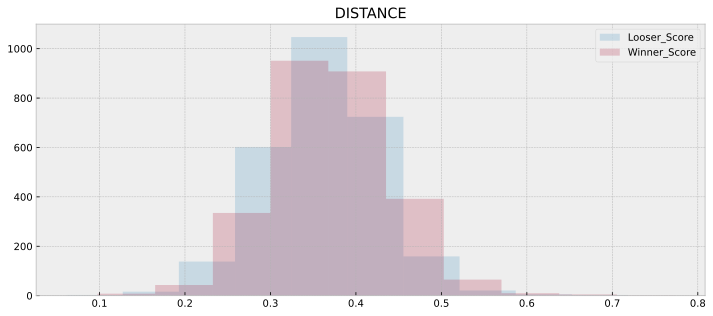

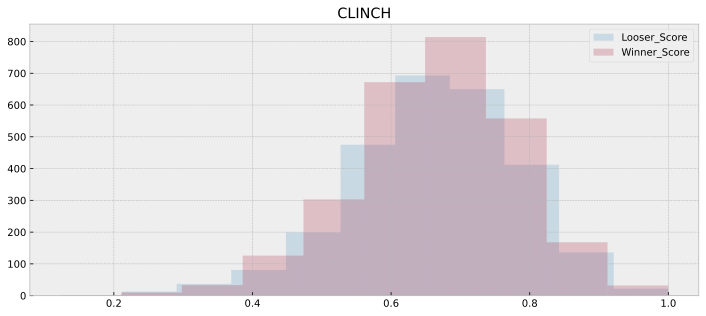

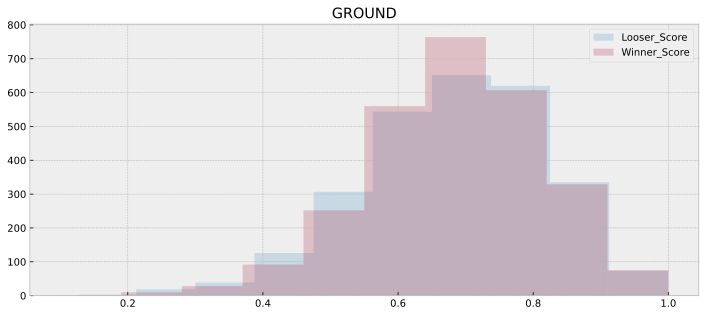

In [7]:
# Question 1 - What is the impact of the variables (percentages) in the final result of the fight?
skill_type = ['KD', 'SIG_STR', 'SUB_ATT', 'TOTAL_STR', 'HEAD', 'BODY', 'LEG', 'DISTANCE', 'CLINCH', 'GROUND']
# Remove all the rows that have any sort of empty value, because we cant trust on the data
q1_data = kaggle_data.dropna(axis = 0, how = 'any')
# Remove draw from the q1_data
q1_data = q1_data[q1_data['Winner'] != 'Draw']
# Remove pct from the q1_data
q1_data.columns = q1_data.columns.str.replace('_pct', '')

q1_dict = {}
for skill in skill_type:
    q1_dict['w_' + skill] = np.where(q1_data['Winner'] == 'Red', (q1_data['R_avg_'+ skill] + q1_data['B_avg_opp_' + skill])/2 , (q1_data['B_avg_' + skill] + q1_data['R_avg_opp_' + skill])/2)
    q1_dict['l_' + skill] = np.where(q1_data['Winner'] == 'Red', (q1_data['B_avg_' + skill] + q1_data['R_avg_opp_' + skill])/2 , (q1_data['R_avg_' + skill] + q1_data['B_avg_opp_' + skill])/2)


%matplotlib inline
plt.style.use('bmh')
from pylab import rcParams
# plots in svg look more precise
%config InlineBackend.figure_format = 'svg'

DEFAULT_FIGSIZE = (12,5)

plt.rcParams['figure.figsize'] = DEFAULT_FIGSIZE

descriptive_stats = pd.DataFrame(q1_dict).describe()

for skill in skill_type:
    plt.hist(q1_dict['l_' + skill], alpha = 0.2, label = 'Looser_Score')
    plt.hist(q1_dict['w_' + skill], alpha = 0.2, label = 'Winner_Score')
    plt.legend(loc = 'upper right')
    plt.title(skill)
    plt.show()


### Implement Predictive Models and Variable Importance (Logistic Regression / Random Forest)

#### Data preparation

<AxesSubplot:xlabel='Winner', ylabel='count'>

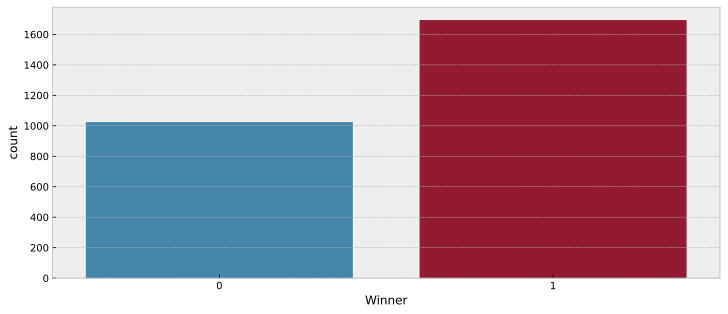

In [8]:
# Data preparation - Part 1

# Remove fighter names 
pred_models_data = q1_data.drop(['R_fighter', 'B_fighter'], axis=1)
# Transform target variable
pred_models_data['Winner'] = np.where(pred_models_data['Winner'] == 'Blue',0,1)

# Check class imbalance
sns.countplot(x = 'Winner', data = pred_models_data)
############################################################# HW MAKE THIS GRAPH PRETTY ######################################################################
# Titles, Legends and so on 
# As it's not that imbalanced we can procced

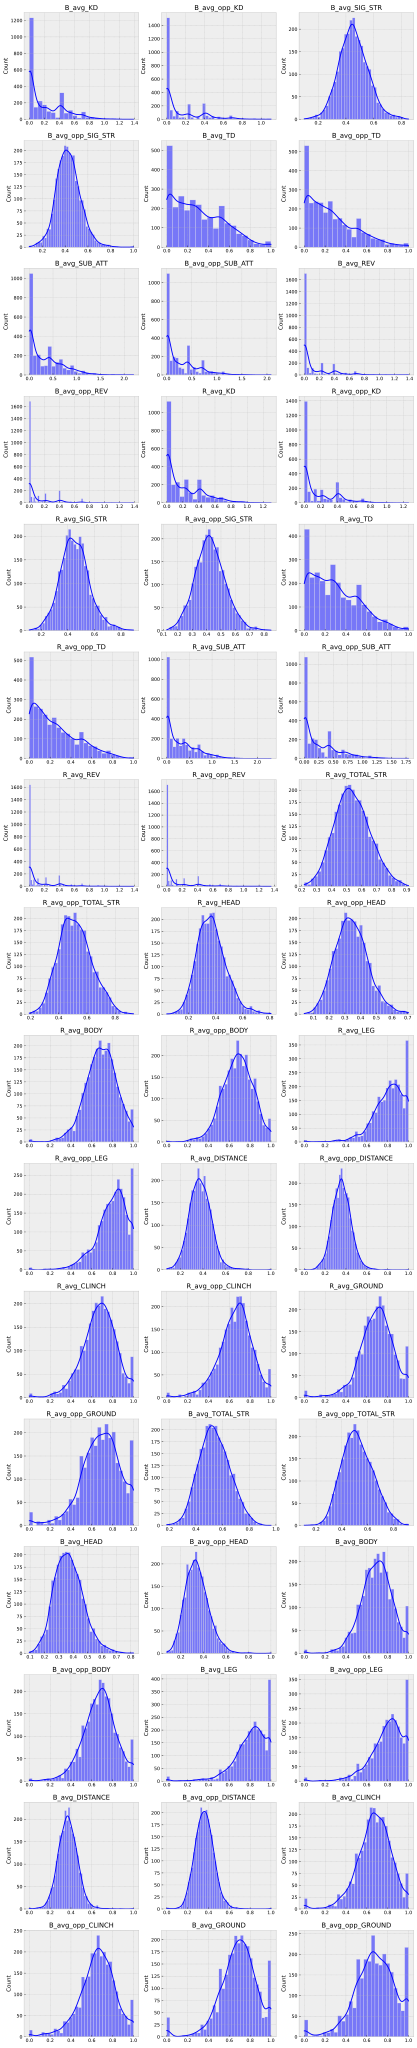

In [10]:
# Data Preparation - Part 2

numeric_values = list(pred_models_data.columns)
numeric_values.remove('Winner')

fig, axes = plt.subplots(16, 3, figsize=(15,80))
for i, ax in enumerate (axes.flat):
    sns.histplot(ax = ax, x=numeric_values[i], data = pred_models_data , kde=True)
    ax.set_title(numeric_values[i])
    ax.set_xlabel('')

log_transformations = ['B_avg_KD', 'B_avg_opp_KD', 'B_avg_SUB_ATT', 'B_avg_opp_SUB_ATT', 'B_avg_REV', 'B_avg_opp_REV', 
'R_avg_KD', 'R_avg_opp_KD', 'R_avg_SUB_ATT', 'R_avg_opp_SUB_ATT', 'R_avg_REV', 'R_avg_opp_REV']

for var_name in log_transformations:
    # Avoid log(0)
    pred_models_data[var_name] = pred_models_data[var_name] + 1
    pred_models_data[var_name] = np.log(pred_models_data[var_name]) 

#### Model Implementation

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RepeatedKFold


# Define Target and the Input Variables

X = pred_models_data.drop(['Winner'], axis=1)
y = pred_models_data['Winner']

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_values)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("Train data shape of X = % s and Y = % s : "%(
    X_train.shape, y_train.shape))
 
print("Test data shape of X = % s and Y = % s : "%(
    X_test.shape, y_test.shape))


Train data shape of X = (2174, 48) and Y = (2174,) : 
Test data shape of X = (544, 48) and Y = (544,) : 


##### Logistic Regression with Regularization

In [12]:
from sklearn.linear_model import LogisticRegression 


# define cross-validation method to use
cv = RepeatedKFold(n_splits=5, random_state=1, n_repeats=10) 

logreg_reg_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LogisticRegression(penalty='elasticnet', solver='saga'))]
)

param_grid = {'model__C': [0.1 , 0.5, 1.0, 5, 10], 'model__l1_ratio': [0.2,0.5,0.7]}

logreg_model_cv = GridSearchCV(logreg_reg_model, param_grid=param_grid , cv = cv)
logreg_model_cv.fit(X_train,y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=1),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['B_avg_KD',
                                                                          'B_avg_opp_KD',
                                                                          'B_avg_SIG_STR',
                                                                          'B_avg_opp_SIG_STR',
                                                                          'B_avg_TD',
                                                                          'B_avg_opp_TD',
                                          

In [13]:
# Display Graphs and Return Classification Metrics
import sklearn.metrics as metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

def classification_metrics_and_graphs(model):
    model_results = {}
    # Predict on Training set
    model_prediction = model.predict(X_test)

    print('Models Best Parameters : ' + str(model.best_params_))

    # Let's start checking the accuracy, although we know that this isn't the best metric for imbalanced datasets like this one
    # Checking accuracy
    model_cv_acc = metrics.accuracy_score(y_test, model_prediction)
    print('The accuracy of this model is : ' + str(model_cv_acc))
    model_results['accuracy'] = model_cv_acc

    # Checking F1_Score
    model_cv_f1 = metrics.f1_score(y_test, model_prediction)
    print('The f1_score of this model is : ' + str(model_cv_f1))
    model_results['F1-Score'] = model_cv_f1

    # Checking Recall_score
    model_cv_recall = metrics.recall_score(y_test, model_prediction)
    print('The recall_score of this model is : ' + str(model_cv_recall))
    model_results['recall'] = model_cv_recall

    # Checking Precision_score
    model_cv_precision = metrics.precision_score(y_test, model_prediction)
    print('The precision_score of this model is : ' + str(model_cv_precision))
    model_results['precision'] = model_cv_precision

    # Confusion Matrix

    # Confusion Matrix
    unique_label = np.unique([y_test, model_prediction])
    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, model_prediction), 
    index=['true:{:}'.format(x) for x in unique_label], 
    columns=['pred:{:}'.format(x) for x in unique_label])

    print('CONFUSION MATRIX : \n')
    print(confusion_matrix_df)

    # Plot ROC-AUC 
    try:
        y_pred_proba = model.predict_proba(X_test)[::,1]
    except AttributeError:
        print('Predict_proba is not available for this model')
        # SVC: Probability = True 
        # This must be enabled prior to calling fit, will slow down that method as it internally uses 5-fold cross-validation, 
        # and predict_proba may be inconsistent with predict. So, for the regular SVC, I won't chose this option.
    else:
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        auc = metrics.roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
        plt.legend(loc=4)
        plt.show()


Models Best Parameters : {'model__C': 0.1, 'model__l1_ratio': 0.7}
The accuracy of this model is : 0.6580882352941176
The f1_score of this model is : 0.7742718446601943
The recall_score of this model is : 0.9114285714285715
The precision_score of this model is : 0.6729957805907173
CONFUSION MATRIX : 

        pred:0  pred:1
true:0      39     155
true:1      31     319


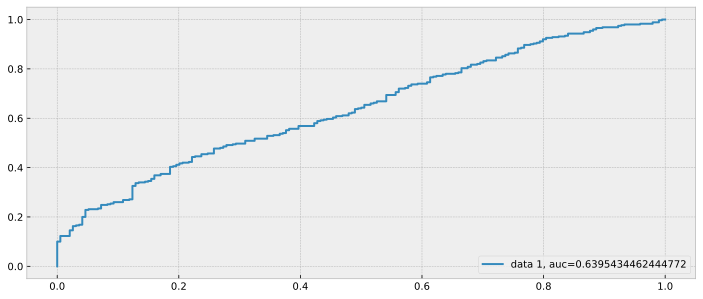

In [14]:
classification_metrics_and_graphs(logreg_model_cv)

##### Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

#%%capture
# define cross-validation method to use
cv = RepeatedKFold(n_splits=5, random_state=1, n_repeats=10) 

random_forest_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", RandomForestClassifier() )]
)

param_grid = {'model__n_estimators': [100, 150, 200]}

random_forest_cv = GridSearchCV(random_forest_model, param_grid=param_grid , cv = cv)
random_forest_cv.fit(X_train,y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=1),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['B_avg_KD',
                                                                          'B_avg_opp_KD',
                                                                          'B_avg_SIG_STR',
                                                                          'B_avg_opp_SIG_STR',
                                                                          'B_avg_TD',
                                                                          'B_avg_opp_TD',
                                          

Models Best Parameters : {'model__n_estimators': 200}
The accuracy of this model is : 0.6378676470588235
The f1_score of this model is : 0.765196662693683
The recall_score of this model is : 0.9171428571428571
The precision_score of this model is : 0.656441717791411
CONFUSION MATRIX : 

        pred:0  pred:1
true:0      26     168
true:1      29     321


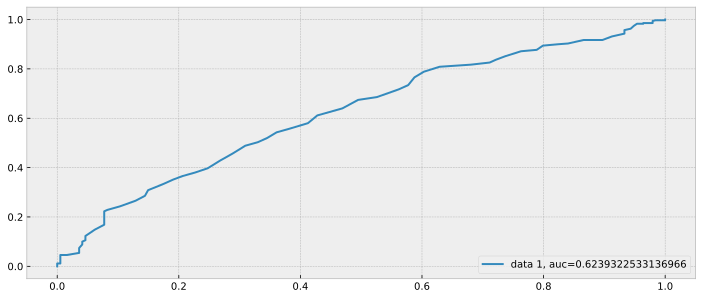

In [16]:
classification_metrics_and_graphs(random_forest_cv)

## Question 2 - What are the main winning methods and it's subcategories? - Webscrapped Data

In [17]:
import plotly.graph_objs as go

In [18]:
webscrapped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6518 entries, 0 to 6517
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   winner_fighter          6518 non-null   object
 1   looser_fighter          6518 non-null   object
 2   match_number            6518 non-null   object
 3   referee                 6518 non-null   object
 4   number_rounds           6518 non-null   object
 5   round_time              6518 non-null   object
 6   weight_class            6518 non-null   object
 7   event_date              6518 non-null   object
 8   event_location          6518 non-null   object
 9   event_name              6518 non-null   object
 10  total_fight_in_seconds  6518 non-null   int64 
 11  method_category         6518 non-null   object
 12  method_subcategory      6518 non-null   object
dtypes: int64(1), object(12)
memory usage: 662.1+ KB


<AxesSubplot:xlabel='method_category', ylabel='num_fights'>

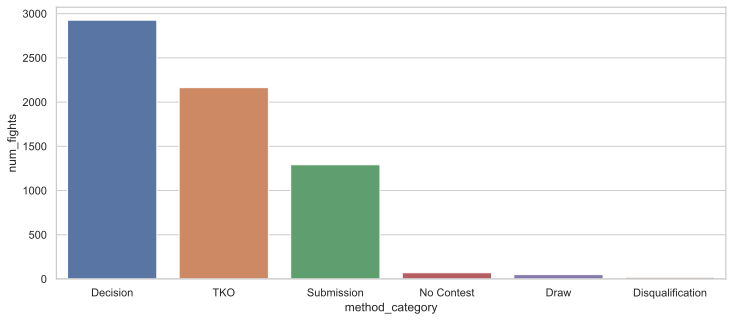

In [19]:
toplot = webscrapped.groupby(['method_category']).size().reset_index().rename(columns={0: 'num_fights'})
sns.set_theme(style="whitegrid")
sns.barplot(x="method_category", y="num_fights", data=toplot, order=toplot.sort_values('num_fights', ascending=False).method_category)
# Please make this graph pretty 
# Titles , labels, etc.

In [20]:
toplot = webscrapped.groupby(['method_category', 'method_subcategory']).size().reset_index().rename(columns={0: 'num_fights'})
import plotly.graph_objects as px
import numpy
  
plot = px.Figure(data=[go.Bar(
    name='Decision',
    x=toplot[toplot['method_category'] == 'Decision'].sort_values('num_fights', ascending=False)['method_subcategory'],
    y=toplot[toplot['method_category'] == 'Decision'].sort_values('num_fights', ascending=False)['num_fights']
),
    go.Bar(
    name='No Contest',
    x=toplot[toplot['method_category'] == 'No Contest'].sort_values('num_fights', ascending=False)['method_subcategory'],
    y=toplot[toplot['method_category'] == 'No Contest'].sort_values('num_fights', ascending=False)['num_fights']
),
    go.Bar(
    name='TKO',
    x=toplot[toplot['method_category'] == 'TKO'].sort_values('num_fights', ascending=False)['method_subcategory'][0:9],
    y=toplot[toplot['method_category'] == 'TKO'].sort_values('num_fights', ascending=False)['num_fights'][0:9]
),
    go.Bar(
    name='Submission',
    x=toplot[toplot['method_category'] == 'Submission'].sort_values('num_fights', ascending=False)['method_subcategory'][0:9],
    y=toplot[toplot['method_category'] == 'Submission'].sort_values('num_fights', ascending=False)['num_fights'][0:9]
),
    go.Bar(
    name='Draw',
    x=toplot[toplot['method_category'] == 'Draw'].sort_values('num_fights', ascending=False)['method_subcategory'],
    y=toplot[toplot['method_category'] == 'Draw'].sort_values('num_fights', ascending=False)['num_fights']
),
    go.Bar(
    name='Disqualification',
    x=toplot[toplot['method_category'] == 'Disqualification'].sort_values('num_fights', ascending=False)['method_subcategory'],
    y=toplot[toplot['method_category'] == 'Disqualification'].sort_values('num_fights', ascending=False)['num_fights']
)
])
  
  
# Add dropdown
plot.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([      
                dict(label="Decision",
                     method="update",
                     args=[{"visible": [True, False, False, False, False, False]},
                           {"title": "Method - Decision",
                            }]),
                dict(label="No Contest",
                     method="update",
                     args=[{"visible": [False, True, False, False, False, False]},
                           {"title": "Method - No Contest",
                            }]),
                dict(label="TKO",
                     method="update",
                     args=[{"visible": [False, False, True, False, False, False]},
                           {"title": "Method - TKO",
                            }]),
                dict(label="Submission",
                     method="update",
                     args=[{"visible": [False, False, False, True, False, False]},
                           {"title": "Method - Submission",
                            }]),
                dict(label="Draw",
                     method="update",
                     args=[{"visible": [False, False, False, False, True, False]},
                           {"title": "Method - Draw",
                            }]),
                dict(label="Disqualification",
                     method="update",
                     args=[{"visible": [False, False, False, False, False, True]},
                           {"title": "Method - Disqualification",
                            }]),
            ])
        )
    ])
  
plot.show()

# HW make pretty

## Extra - Cluster the fighters

In [21]:
# Data Preparation

# Kaggle Data
red_cols = list(q1_data.filter(like='R_').columns)
red_cols.remove('R_fighter')
blue_cols = list(q1_data.filter(like='B_').columns)
blue_cols.remove('B_fighter')

part_red = q1_data.groupby(['R_fighter'])[red_cols].mean().reset_index()
part_blue = q1_data.groupby(['B_fighter'])[blue_cols].mean().reset_index()

part_red.columns = part_red.columns.str.replace('R_', '')
part_blue.columns = part_blue.columns.str.replace('B_', '')

final_kaggle = pd.concat([part_red, part_blue])
final_kaggle = final_kaggle.groupby('fighter').mean().reset_index()

# Webscrapped Data

# Remove unecessary columns
web_cluster_data = webscrapped.drop(['match_number', 'referee', 'number_rounds','round_time', 'method_subcategory', 'event_name', 'event_location', 'event_date'], axis=1)
# Category
part_method_win = pd.crosstab(web_cluster_data['winner_fighter'], web_cluster_data['method_category']).reset_index()
part_method_looser = pd.crosstab(web_cluster_data['looser_fighter'], web_cluster_data['method_category']).reset_index()
final_method = part_method_looser.merge(part_method_win, left_on='looser_fighter', right_on='winner_fighter',  suffixes=('_los', '_win'))
final_method.drop('looser_fighter', axis = 1, inplace=True)
final_method.rename(columns={'winner_fighter':'fighter'}, inplace = True)

# Total fight sec
win_fight_sec = web_cluster_data.groupby('winner_fighter').mean().reset_index().rename(columns={'total_fight_in_seconds': 'avg_win_fight_time'})
looser_fight_sec = web_cluster_data.groupby('looser_fighter').mean().reset_index().rename(columns={'total_fight_in_seconds': 'avg_loose_fight_time'})
final_fight_sec = win_fight_sec.merge(looser_fight_sec, left_on='winner_fighter', right_on='looser_fighter')
final_fight_sec.drop('looser_fighter', axis = 1, inplace=True)
final_fight_sec.rename(columns={'winner_fighter':'fighter'}, inplace=True)

# FINAL JOINN

cluster_df = final_fight_sec.merge(final_method, how='inner', on = 'fighter')
cluster_df = cluster_df.merge(final_kaggle, how = 'inner', on = 'fighter')
cluster_df.fillna(0, inplace=True)

In [22]:
cluster_df.head()

,fighter,avg_win_fight_time,avg_loose_fight_time,Decision_los,Disqualification_los,Draw_los,No Contest_los,Submission_los,TKO_los,Decision_win,...,avg_DISTANCE,avg_opp_DISTANCE,avg_CLINCH,avg_opp_CLINCH,avg_GROUND,avg_opp_GROUND,avg_SUATT,avg_opp_SUATT,R_avg_SUATT,R_avg_opp_SUATT
0,Aaron Riley,900.000000,503.666667,2,0,0,0,0,4,3,...,0.323698,0.344905,0.627690,0.550866,0.810324,0.535088,0.000000,0.00000,0.000000,0.000000
1,Aaron Simpson,702.428571,671.500000,2,0,0,0,0,2,5,...,0.332832,0.354885,0.736783,0.640432,0.682277,0.859171,0.187500,0.18750,0.000000,1.250000
2,Abdul Razak Alhassan,120.200000,726.000000,4,0,0,0,0,1,0,...,0.393651,0.305263,0.607143,0.785714,0.750000,0.687500,0.000000,0.00000,0.000000,0.000000
3,Abel Trujillo,431.000000,721.000000,2,0,0,1,2,0,1,...,0.319437,0.336744,0.623157,0.558120,0.746185,0.769135,0.141602,1.21875,0.464977,0.497223
4,Adam Milstead,541.000000,479.333333,1,0,0,1,0,1,0,...,0.445575,0.425405,0.657967,0.743056,1.000000,0.851852,0.000000,0.00000,1.000000,0.000000


## Clustering

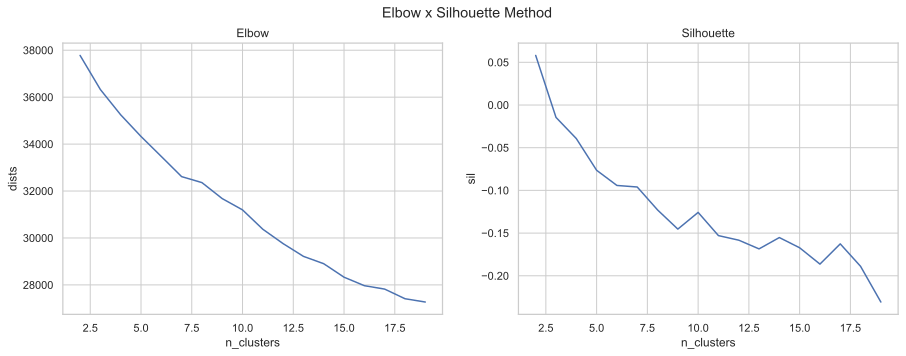

In [23]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

# Your code comes here
kmeans_data =  cluster_df.drop('fighter', axis=1)

# Returns clustering optimal K by Elbow and Silhouette Method

def calculate_WSS_and_Silhouette(dataset, init_method = 'k-means++' , kmax = 20):
  
  fig, axes = plt.subplots(1, 2, figsize=(15,5))
  fig.suptitle('Elbow x Silhouette Method')

  # Elbow Method
  dists = []
  # Silhouette Method
  sil = []

  for cluster_num in range(2, kmax):
    estimator = KMeans(init=init_method, n_clusters=cluster_num)
    # Scaling the dataset is very important due to to the different range sizes
    estimator.fit(scale(dataset))
    dists.append(estimator.inertia_)
    sil.append(silhouette_score(kmeans_data, labels = estimator.labels_ , metric='euclidean'))
  
  # Elbow
  sns.lineplot(ax = axes[0], x='n_clusters', y='dists' , data = pd.DataFrame({'dists':dists, 'n_clusters':list(range(2,kmax))}))
  axes[0].set_title('Elbow')

  # Elbow
  sns.lineplot(ax = axes[1], x='n_clusters', y='sil' , data = pd.DataFrame({'sil':sil, 'n_clusters':list(range(2,kmax))}))
  axes[1].set_title('Silhouette')

calculate_WSS_and_Silhouette(kmeans_data , kmax = 20)
# we can be sure that the optimal number of clusters is 3 selecting the following parameters

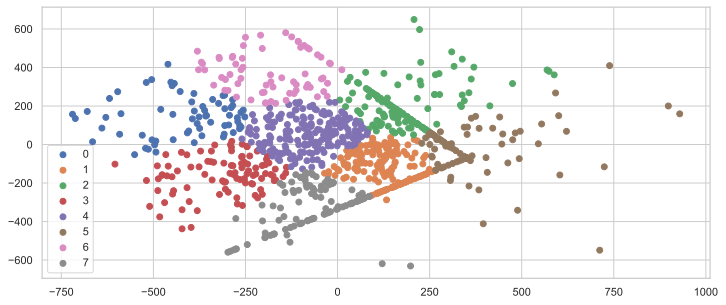

In [26]:
from sklearn.decomposition import PCA
from itertools import combinations

pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(kmeans_data)
 
#Import KMeans module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 8)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()